# Cài đặt các thư viện cần thiết

In [1]:
!pip install transformers datasets
!pip install scikit-learn pandas seaborn

# Load và xử lý dữ liệu

In [2]:
import json
import pandas as pd

# Đọc các file JSON
def load_data(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    return pd.DataFrame(data)

train_df = load_data("/content/train.json")
val_df = load_data("/content/val.json")
test_df = load_data("/content/test.json")

# Gán nhãn số
label2id = {"SUPPORTS": 0, "REFUTES": 1}
train_df["label"] = train_df["label"].map(label2id)
val_df["label"] = val_df["label"].map(label2id)
test_df["label"] = test_df["label"].map(label2id)

In [3]:
texts_train = train_df["claim"] + " [SEP] " + train_df["evidence"]
texts_val = val_df["claim"] + " [SEP] " + val_df["evidence"]
texts_test = test_df["claim"] + " [SEP] " + test_df["evidence"]

In [4]:
labels_train = train_df["label"].values
labels_val = val_df["label"].values
labels_test = test_df["label"].values

# Token hóa và chuyển sang Dataset

In [5]:
from transformers import AutoTokenizer

# Sử dụng tokenizer của mDeBERTa
tokenizer = AutoTokenizer.from_pretrained("microsoft/mdeberta-v3-base")

# Token hóa dữ liệu
train_encodings = tokenizer(list(texts_train), truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(list(texts_val), truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(list(texts_test), truncation=True, padding=True, max_length=256)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [6]:
import torch

class FactCheckDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = FactCheckDataset(train_encodings, labels_train)
val_dataset = FactCheckDataset(val_encodings, labels_val)
test_dataset = FactCheckDataset(test_encodings, labels_test)


# Huấn luyện mô hình MDeBERTa

In [17]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

class FactCheckingModelTrainer:
    def __init__(self, model_name="microsoft/mdeberta-v3-base", num_labels=2, max_length=256):
        self.model_name = model_name
        self.num_labels = num_labels
        self.max_length = max_length
        self.best_metric = float('-inf')

        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            self.model_name,
            num_labels=self.num_labels
        )

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.trainer = None

    @staticmethod
    def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
        acc = accuracy_score(labels, preds)
        return {
            'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall
        }

    def fit(self,
      train_dataset,
      valid_dataset=None,
      output_dir='./results',
      num_train_epochs=3,
      per_device_train_batch_size=8,
      per_device_eval_batch_size=8,
      warmup_steps=500,
      weight_decay=0.01,
      logging_steps=100,
      metric_for_best_model="f1"):

      training_args = TrainingArguments(
          output_dir=output_dir,
          num_train_epochs=num_train_epochs,
          per_device_train_batch_size=per_device_train_batch_size,
          per_device_eval_batch_size=per_device_eval_batch_size,
          learning_rate=2e-5,
          warmup_ratio=0.1,
          weight_decay=weight_decay,
          logging_dir=f'{output_dir}/logs',
          logging_steps=logging_steps,
          save_steps=500,
          save_total_limit=3,
          metric_for_best_model=metric_for_best_model,
          greater_is_better=True,
          disable_tqdm=False,
          report_to="none",
          max_grad_norm=1.0
      )
      self.trainer = Trainer(
          model=self.model,
          args=training_args,
          train_dataset=train_dataset,
          eval_dataset=valid_dataset,
          compute_metrics=self.compute_metrics if valid_dataset is not None else None,
      )

      print("Bắt đầu huấn luyện mô hình...")
      self.trainer.train()
      print("Huấn luyện hoàn tất.")

      # Đánh giá trên tập validation
      if valid_dataset is not None:
          print("\nĐánh giá trên tập validation:")
          eval_results = self.trainer.evaluate()
          print("\nKết quả đánh giá:")
          print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
          print(f"F1-score: {eval_results['eval_f1']:.4f}")
          print(f"Precision: {eval_results['eval_precision']:.4f}")
          print(f"Recall: {eval_results['eval_recall']:.4f}")

    def predict(self, statement, evidence):
        self.model.eval()

        full_text = f"{statement} [SEP] {evidence}"
        inputs = self.tokenizer(
            full_text,
            return_tensors="pt",
            truncation=True,
            padding='max_length',
            max_length=self.max_length
        )
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        predicted_class_id = torch.argmax(probabilities, dim=1).item()
        label_map = {0: "SUPPORTS", 1: "REFUTES"}
        predicted_label = label_map.get(predicted_class_id, str(predicted_class_id))
        return predicted_label, probabilities.cpu().numpy()[0]

    def save_model(self, save_path="./fine_tuned_mdeberta_factcheck"):
        print(f"Lưu mô hình vào {save_path}")
        self.model.save_pretrained(save_path)
        self.tokenizer.save_pretrained(save_path)

In [18]:
trainer = FactCheckingModelTrainer()
trainer.fit(train_dataset, valid_dataset=val_dataset)

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Bắt đầu huấn luyện mô hình...


Step,Training Loss
100,0.696500
200,0.677900
300,0.482400
400,0.355000
500,0.347200
600,0.400800
700,0.337400
800,0.334100
900,0.283600
1000,0.302600


Huấn luyện hoàn tất.

Đánh giá trên tập validation:



Kết quả đánh giá:
Accuracy: 0.9528
F1-score: 0.9529
Precision: 0.9546
Recall: 0.9528


In [19]:
trainer.save_model("./fine_tuned_mdeberta_factcheck")

Lưu mô hình vào ./fine_tuned_mdeberta_factcheck


# Hàm đánh giá test_evaluate

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_on_testset(trainer, test_dataset, label_names=["SUPPORTS", "REFUTES"]):
    print("📊 Đang đánh giá trên tập test...")
    predictions = trainer.trainer.predict(test_dataset)
    y_true = predictions.label_ids
    y_pred = np.argmax(predictions.predictions, axis=1)

    # In báo cáo phân loại
    print("\n=== Báo cáo phân loại ===")
    print(classification_report(y_true, y_pred, target_names=label_names, digits=4))

    # Tính ma trận nhầm lẫn
    cm = confusion_matrix(y_true, y_pred)

    # Vẽ biểu đồ
    plt.figure(figsize=(6, 5))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Dự đoán")
    plt.ylabel("Thực tế")
    plt.title("🔍 Ma trận nhầm lẫn trên tập test")
    plt.tight_layout()
    plt.show()

📊 Đang đánh giá trên tập test...



=== Báo cáo phân loại ===
              precision    recall  f1-score   support

    SUPPORTS     0.9661    0.9358    0.9507       670
     REFUTES     0.9232    0.9592    0.9409       539

    accuracy                         0.9462      1209
   macro avg     0.9447    0.9475    0.9458      1209
weighted avg     0.9470    0.9462    0.9463      1209



<ipython-input-20-a692662f71c8>:26: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


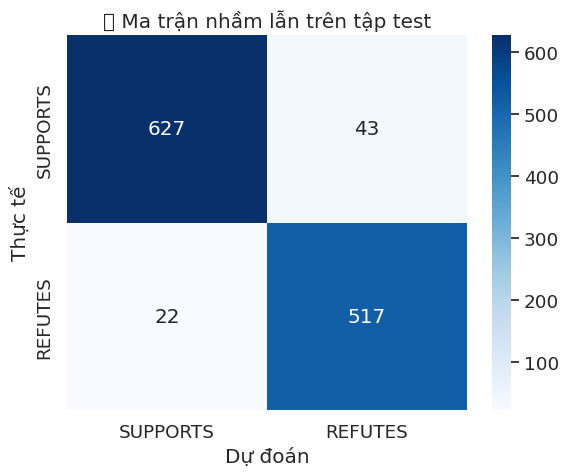

In [21]:
evaluate_on_testset(trainer, test_dataset, label_names=["SUPPORTS", "REFUTES"])